# Convolution Neural Network

#### Accuracy: 99.83%

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

In [35]:
data = pd.read_csv('sign_mnist_train.csv')
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [36]:
x = data.iloc[:, 1:].values
y = data.iloc[:, :1].values.flatten()

In [37]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [38]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

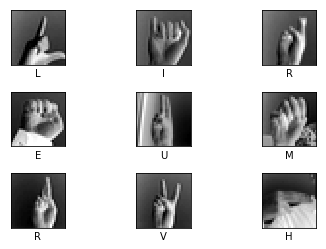

In [39]:
display_images(next_batch(9, x, y))

In [40]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)

In [41]:
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100
# Neural Network Hyperparameters
n_input = 784
n_classes = 25
dropout = 0.75
# Placeholders
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [42]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [43]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [44]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [45]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [46]:
logits = neural_network(X, weights, biases, keep_prob)
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)

In [48]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

Epoch 100, Cost: 125011662.625, Accuracy: 44.53125 %
Epoch 200, Cost: 34040799.1875, Accuracy: 69.53125 %
Epoch 300, Cost: 9009344.625, Accuracy: 84.375 %
Epoch 400, Cost: 3952629.3125, Accuracy: 89.84375 %
Epoch 500, Cost: 3428015.5625, Accuracy: 91.40625 %
Epoch 600, Cost: 1917948.25, Accuracy: 92.1875 %
Epoch 700, Cost: 534346.9375, Accuracy: 96.09375 %
Epoch 800, Cost: 538829.90625, Accuracy: 97.65625 %
Epoch 900, Cost: 260820.625, Accuracy: 96.09375 %
Epoch 1000, Cost: 316312.375, Accuracy: 97.65625 %
Epoch 1100, Cost: 57652.875, Accuracy: 98.4375 %
Epoch 1200, Cost: 185435.5, Accuracy: 99.21875 %
Epoch 1300, Cost: 0.0, Accuracy: 100.0 %
Epoch 1400, Cost: 47226.25, Accuracy: 99.21875 %
Epoch 1500, Cost: 0.0, Accuracy: 100.0 %
Epoch 1600, Cost: 0.0, Accuracy: 100.0 %
Epoch 1700, Cost: 0.0, Accuracy: 100.0 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 126697.875, Accuracy: 99.21875 %
Epoch 2000, Cost: 0.0, Accuracy: 100.0 %
--------------------------------------------

In [49]:
print('Training on the whole dataset....\n')
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x, y_encoded)
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X : _x,
                     Y : _y,
                     keep_prob : dropout
                 })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy],
                                 feed_dict = {
                                     X : _x,
                                     Y : _y,
                                     keep_prob : 1.0
                                 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : x,
                                                           Y : y_encoded,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    
    W = sess.run(weights)
    B = sess.run(biases)

Training on the whole dataset....

Epoch 100, Cost: 86290330.125, Accuracy: 52.34375 %
Epoch 200, Cost: 35767075.0, Accuracy: 66.40625 %
Epoch 300, Cost: 11348862.125, Accuracy: 77.34375 %
Epoch 400, Cost: 5311494.1875, Accuracy: 85.15625 %
Epoch 500, Cost: 973803.40625, Accuracy: 92.96875 %
Epoch 600, Cost: 1017365.0625, Accuracy: 93.75 %
Epoch 700, Cost: 181569.375, Accuracy: 97.65625 %
Epoch 800, Cost: 93392.0625, Accuracy: 98.4375 %
Epoch 900, Cost: 672974.390625, Accuracy: 96.09375 %
Epoch 1000, Cost: 494097.21875, Accuracy: 96.875 %
Epoch 1100, Cost: 0.0, Accuracy: 100.0 %
Epoch 1200, Cost: 65568.25, Accuracy: 99.21875 %
Epoch 1300, Cost: 0.0, Accuracy: 100.0 %
Epoch 1400, Cost: 0.0, Accuracy: 100.0 %
Epoch 1500, Cost: 0.0, Accuracy: 100.0 %
Epoch 1600, Cost: 110428.625, Accuracy: 99.21875 %
Epoch 1700, Cost: 0.0, Accuracy: 100.0 %
Epoch 1800, Cost: 18128.9375, Accuracy: 99.21875 %
Epoch 1900, Cost: 0.0, Accuracy: 100.0 %
Epoch 2000, Cost: 0.0, Accuracy: 100.0 %
-----------------

In [50]:
data_test = pd.read_csv('sign_mnist_test.csv')

In [51]:
x_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, :1].values.flatten()
y_test = one_hot_encode(y_test)

In [52]:
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [53]:
y_pred = neural_network(X, W, B, 1.0)

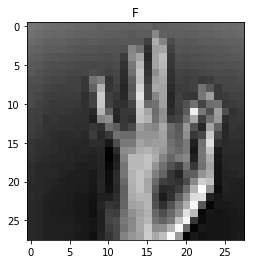

In [55]:
def get_prediction(img):
    with tf.Session() as sess:
        pred = sess.run(y_pred, feed_dict = { X : img, keep_prob : 1.0 })
    img = img.reshape(28, 28)
    pred = list(pred.flatten())
    pred = chr(pred.index(max(pred)) + 65)
    return (img, pred)
image, pred = get_prediction(x_test[1].reshape(1, 784))
plt.imshow(image, cmap = 'binary')
plt.title(pred)
plt.show()